<a href="https://colab.research.google.com/github/kkrree/todaysPython/blob/master/%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EC%84%9D_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 머신러닝 텍스트 분류실습
source : https://www.youtube.com/playlist?list=PLaTc2c6yEwmp35y9Z868VlV9NQpG-eBb6

머신러닝 기법 분류
![이미지](https://i.imgur.com/b6wcQ7f.png)

데이터 분석 및 머신러닝 적용 프로세스
![이미지](https://i.imgur.com/li0a2zj.png)



```
# 참고
scikit-learn 1.0 이상 버전 사용 권장 (sklearn__version__ 으로 확인)
1.0 이하의 버전이라면 conda prompt 혹은 터미널을 열어 아래 명령어로 업그레이드
conda : conda update scikit-learn
pip install scikit-learn --upgrade
```


In [93]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(Colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

plt.style.use("seaborn")
plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

%config InlineBackend.figure_format = 'retina'

<ipython-input-93-c9cfe92b4a64>:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

AttributeError: ignored

### 데이터 셋 준비

In [56]:
#드라이브에서 파일 가져오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# 라이브러리 및 파일 불러오기
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = "/content/drive/MyDrive/Nexon_Assignment/"
content =pd.read_csv(path + "content.csv")
comment =pd.read_csv(path + "comment.csv")

### 정답 데이터 만들기

In [58]:
# loc[행, 열]
# loc[조건, 열]
# loc[조건, 열] = 대체값 으로 특정 열에 해당하는 값을 변경
# "코로나"가 포함이면 "보건"으로 나머지는 "교통" 으로 정답을 레이블링comment
comment = comment.head(10000)
comment.loc[comment['likeCount'] > 0 , 'likeComment'] = "like"
comment.loc[comment['likeCount'] == 0 , 'likeComment'] = "-"
comment[['text','likeCount','likeComment']]

,text,likeCount,likeComment
0,Ln 로비파울러 좋나요??,0,-
1,루니 개좋음 ㄹㅇ 감차예술,1,like
2,형 한국 공미 캡 흥민 5카 vs 12kh지동원6카 중에 뭐 써야되요?,0,-
3,지금 300억이면 어지간한 좋은팀 나올듯요ㅎㅎㅎ 시세가 그렇다보니,0,-
4,급여 220 700억 맨시티 홀란쓰고 부탁드립니다 ㅠㅠ,0,-
...,...,...,...
9995,영상소리가 좀 작게 인코딩 된듯,3,like
9996,지배서 바드면 이게~,27,like
9997,피씨이~방 하린이 안대,3,like
9998,근데 피파대낙을 신청하게 되면은,2,like


### 텍스트 데이터 수치 형태로 변경

In [59]:
# sklearn.feature_extraction.text의 CountVectorizer 로 BOW 벡터화
# fit_transform 으로 훈련 및 변환
from sklearn.feature_extraction.text import CountVectorizer 
cvect = CountVectorizer()
dtm = cvect.fit_transform(comment['text']) 
dtm # sparse matrix 희소행렬로 변환된 것 확인

<10000x3125 sparse matrix of type '<class 'numpy.int64'>'
	with 60835 stored elements in Compressed Sparse Row format>

### DTM(document-term matrix)

In [60]:
# 피처 가져오기
featureNames = cvect.get_feature_names_out()
featureNames

array(['00', '000fc', '05', ..., '힘들어요', '힘들어용', '힘들지ㅋㅋ'], dtype=object)

In [ ]:
# 단어 사전 보기
cvect.vocabulary_

In [62]:
# dtm(document-term matrix)
pd.DataFrame(dtm.toarray(), columns = featureNames)

,00,000fc,05,07,08,08맨유,08맨유는,10,1000억,100억,...,흑우노,흥민,희한하게,힐플릭인가요,힘들,힘들것,힘들까,힘들어요,힘들어용,힘들지ㅋㅋ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 문제와 정답 만들기

In [63]:
# 독랍변수로 사용할 x 변수에 dtm array를 할당
X = dtm.toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [64]:
# 종속변수로 사용할 변수에 정답값인  값 할당
Y = comment['likeComment']
Y

0          -
1       like
2          -
3          -
4          -
        ... 
9995    like
9996    like
9997    like
9998    like
9999    like
Name: likeComment, Length: 10000, dtype: object

### 데이터셋 나누기
* 현재 예제에서는 임의로 나눔
* test_train_split 을 활용하여 나눌 수 있음

In [65]:
# 8:2 의 비율로 구하기 위해 전체 데이터의 행에서 80% 위치에 해당되는 값을 구해서 split_count 라는 변수에 담습니다.
splitCount = int(comment.shape[0]*0.8)
splitCount

8000

In [66]:
# 학습 세트 만들기
X_train = X[:splitCount]
Y_train = Y[:splitCount]
print(X_train.shape, Y_train.shape) # 행 갯수 같은지 확인
X_train, Y_train

(8000, 3125) (8000,)


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), 0          -
 1       like
 2          -
 3          -
 4          -
         ... 
 7995       -
 7996       -
 7997       -
 7998    like
 7999       -
 Name: likeComment, Length: 8000, dtype: object)

In [67]:
# 예측 세트 만들기
X_test = X[splitCount:]
Y_test = Y[splitCount:]
print(X_test.shape, Y_test.shape) # 행 갯수 같은지 확인
X_test, Y_test

(2000, 3125) (2000,)


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), 8000       -
 8001       -
 8002       -
 8003    like
 8004    like
         ... 
 9995    like
 9996    like
 9997    like
 9998    like
 9999    like
 Name: likeComment, Length: 2000, dtype: object)

### 머신러닝 모델 로드하기

In [68]:
# DecisionTreeClassifier 사용
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model

DecisionTreeClassifier()

### 학습(훈련)

In [69]:
# fit(문제, 정답)
model.fit(X_train,Y_train)

DecisionTreeClassifier()

### 예측

In [70]:
# predict(실전문제)
Y_predict = model.predict(X_test)
Y_predict

array(['like', '-', '-', ..., '-', '-', '-'], dtype=object)

### 평가 
#### 정확도(Accuracy) 측정하기

In [71]:
# 예측의 정확도를 구합니다. 100점 만점 중에 몇 점을 맞았는지 구한다고 보면 됩니다.
(Y_test == Y_predict).mean()*100

68.89999999999999

In [72]:
# 위에서 처럼 직접 구할 수도 있지만 미리 구현된 알고리즘을 가져와 사용합니다.
# sklearn.metrics 의 accuracy_score 를 가져옵니다.
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_predict)

0.689

In [78]:
# crosstab 으로 confusion matrix 를 구합니다.
pd.crosstab(Y_test,Y_predict)

col_0,-,like
likeComment,,
-,1220,140
like,482,158


In [79]:
# confusion_matrix 를 통해 구할 수도 있습니다.
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,Y_predict)

array([[1220,  140],
       [ 482,  158]])

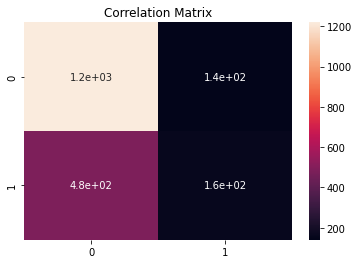

In [80]:
# correlation marix 시각화
corr_matrix = confusion_matrix(Y_test,Y_predict)
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

### 트리 알고리즘 분석하기
#### 의사결정나무를 시각화 합니다.

In [81]:
# export_text 로 트리 분석하기
from sklearn.tree import export_text
print(export_text(model))

|--- feature_649 <= 0.50
|   |--- feature_2872 <= 0.50
|   |   |--- feature_740 <= 0.50
|   |   |   |--- feature_1019 <= 0.50
|   |   |   |   |--- feature_1869 <= 0.50
|   |   |   |   |   |--- feature_441 <= 0.50
|   |   |   |   |   |   |--- feature_1204 <= 0.50
|   |   |   |   |   |   |   |--- feature_2586 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_2187 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_1997 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_2934 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 321
|   |   |   |   |   |   |   |   |   |   |--- feature_2934 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: like
|   |   |   |   |   |   |   |   |   |--- feature_1997 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_2147 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: like
|   |   |   |   |   |   |   |   |   |   |--- feature_2147 >  0.50
|   |   |   |   |   |   |   |   |   

/usr/local/lib/python3.9/dist-packages/sklearn/tree/_export.py:676: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_export.py:676: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_export.py:676: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_export.py:676: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_export.py:676: UserWarning: Glyph 54168 (\N{HANGUL SYLLABLE PE}) missing from current font.
  ann.update_bbox_position_size(renderer)
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_export.py:6

[Text(0.7894736842105263, 0.9583333333333334, '구단가치 <= 0.5\ngini = 0.413\nsamples = 8000\nvalue = [5665, 2335]'),
 Text(0.6842105263157895, 0.875, '페드로 <= 0.5\ngini = 0.402\nsamples = 7732\nvalue = [5577, 2155]'),
 Text(0.631578947368421, 0.7916666666666666, '금카까지 <= 0.5\ngini = 0.397\nsamples = 7670\nvalue = [5577, 2093]'),
 Text(0.5789473684210527, 0.7083333333333334, '되나요 <= 0.5\ngini = 0.392\nsamples = 7614\nvalue = [5577, 2037]'),
 Text(0.5263157894736842, 0.625, '아니 <= 0.5\ngini = 0.387\nsamples = 7565\nvalue = [5577, 1988]'),
 Text(0.42105263157894735, 0.5416666666666666, 'ㅋㅋㅋㅋㅋ <= 0.5\ngini = 0.382\nsamples = 7493\nvalue = [5567, 1926]'),
 Text(0.3684210526315789, 0.4583333333333333, '말고 <= 0.5\ngini = 0.378\nsamples = 7449\nvalue = [5567, 1882]'),
 Text(0.3157894736842105, 0.375, '지금은 <= 0.5\ngini = 0.374\nsamples = 7411\nvalue = [5567, 1844]'),
 Text(0.2631578947368421, 0.2916666666666667, '우파메카노 <= 0.5\ngini = 0.37\nsamples = 7373\nvalue = [5567, 1806]'),
 Text(0.21052631578

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 50732 (\N{HANGUL SYLLABLE OL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  func(*args, **kwarg

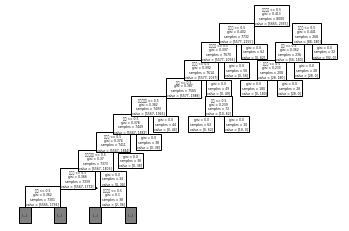

In [88]:
# plot_tree 로 시각화 하기
from sklearn.tree import plot_tree
plot_tree(model,feature_names = featureNames, max_depth =10)

In [98]:
# feature_importances_로 피처 중요도 확인하기
model.feature_importances_

array([1.47451682e-08, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47592 (\N{HANGUL SYLLABLE MAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46104 (\N{HANGUL SYLLABLE DOE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPyth

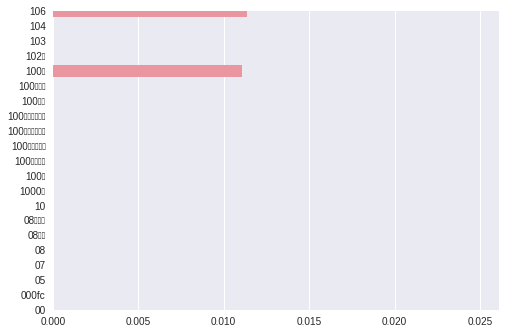

In [97]:
# sort the x values in descending order
sorted_featureImportances = model.feature_importances_[::-1].argsort()[::-1]

sns.barplot(x=model.feature_importances_[sorted_featureImportances], y=featureNames)
plt.ylim(0, 20)
plt.show()